In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random


In [2]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [3]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [5]:
def shout(text: Annotated[str, "something to shout about"]) -> str:
    print(text.upper() + "!!!")
    return text.upper() + "!!!"

shout("hello world")

HELLO WORLD!!!


'HELLO WORLD!!!'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.




### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [6]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

### Step 2: Start the Graph Builder with this State class

In [8]:
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [12]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}!"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [13]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

### Step 5: Compile the Graph

In [14]:
graph = graph_builder.compile()

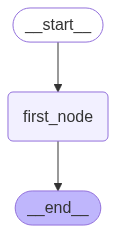

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [ ]:
def chat(user_input: str, history):

    message = {"role": "user", "content": user_input}
    message = [message]
    state = State(messages=message)
    result = graph.invoke(state)
    print(result)

    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hai', additional_kwargs={}, response_metadata={}, id='a03beede-6ce9-4c16-9d2c-a4d6c42dfa6e'), AIMessage(content='Muffins are smelly!', additional_kwargs={}, response_metadata={}, id='9482f437-1992-4862-ae27-ca43523b277f')]}
{'messages': [HumanMessage(content="I'm handsome", additional_kwargs={}, response_metadata={}, id='59f595cb-c596-4eb5-a8ed-832f27d6b36b'), AIMessage(content='Muffins are sparkly!', additional_kwargs={}, response_metadata={}, id='935ed749-ff98-4bbf-bd24-0a57ff06e88d')]}
{'messages': [HumanMessage(content='so?', additional_kwargs={}, response_metadata={}, id='c410e7b2-10ea-4cb5-922a-5e440155254b'), AIMessage(content='Eels are sarcastic!', additional_kwargs={}, response_metadata={}, id='ba0151d9-caf4-4a22-9608-dceab5707989')]}


### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [18]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [19]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)


In [21]:
# Step 3: Create a Node

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:

    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])

    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [22]:
# Step 4: Create edges

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

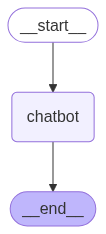

In [23]:
# Step 5: Compile the Graph

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [ ]:
def chat(user_input: str, history):
    
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hai', additional_kwargs={}, response_metadata={}, id='6a127da3-ac29-4b2d-b4e6-33ebcda627dc'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C8i0DWfQKL1cSXS9HwKYvC9vfjWJo', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0724393c-9c54-45ec-8b59-c8b8e3f3f8de-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [HumanMessage(content='ho

Bad pipe message: %s [b"\x8b7V\xffv\xdb\raq\xcb'\x14\x12QB\xe4\xe2\xa5\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00"]
Bad pipe message: %s [b"\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\x